In [1]:
# imports
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

/Users/lucasbrown/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# use a list of the NasDAQ-100 companies
nasdaq100_tickers = [
    "AAPL", "ABNB", "ADBE", "ADI", "ADP", "ADSK", "AEP", "AMD", "AMAT", "AMGN",
    "AMZN", "APP", "ARM", "ASML", "AVGO", "AXON", "AZN", "BIIB", "BKNG", "BKR",
    "CCEP", "CDNS", "CDW", "CEG", "CHTR", "CMCSA", "COST", "CPRT", "CRWD", "CSCO",
    "CSGP", "CSX", "CTAS", "CTSH", "DASH", "DDOG", "DXCM", "EA", "EXC", "FANG",
    "FAST", "FTNT", "GEHC", "GFS", "GILD", "GOOG", "GOOGL", "HON", "IDXX", "INTC",
    "INTU", "ISRG", "KDP", "KHC", "KLAC", "LIN", "LRCX", "LULU", "MAR", "MCHP",
    "MDLZ", "MELI", "META", "MNST", "PEP", "PLTR", "PYPL", "QCOM", "REGN", "ROP",
    "ROST", "SBUX", "SHOP", "SNPS", "TEAM", "TMUS", "TSLA", "TTD", "TTWO", "TXN",
    "VRSK", "VRTX", "WBD", "WDAY", "XEL", "ZS"
]

# load eveyrthing into seperate csv files
directory = "nasdaq100_data"
if not os.path.exists(directory):
    os.makedirs(directory)

for ticker in nasdaq100_tickers:
    csv_path = os.path.join(directory, f"{ticker}.csv")
    if os.path.exists(csv_path):
        continue
    data = yf.Ticker(ticker).history(start='2010-01-01', end='2024-10-31')
    data.to_csv(csv_path)


In [3]:
holder = {}

for symbol in nasdaq100_tickers:
    csv_path = os.path.join(directory, f"{symbol}.csv")
    if not os.path.exists(csv_path):
        continue

    df = pd.read_csv(
        csv_path,
        parse_dates=["Date"],
        index_col="Date",
        usecols=["Date", "Open", "Close"]
    )

    # Convert to proper DatetimeIndex and remove timezone
    df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)

    # Sort for clean slicing
    df = df.sort_index()

    holder[symbol] = df

In [4]:
holder["AAPL"].head() 

,Open,Close
Date,,
2010-01-04 05:00:00,6.400987,6.418382
2010-01-05 05:00:00,6.436077,6.429479
2010-01-06 05:00:00,6.429479,6.327210
2010-01-07 05:00:00,6.350602,6.315512
2010-01-08 05:00:00,6.307116,6.357501


In [5]:
def compute_polynomial_bands(df, degree=4, window=60, k=2):
    df['Poly_Center'] = np.nan
    df['Upper_Band'] = np.nan
    df['Lower_Band'] = np.nan

    closes = df['Close'].values

    for i in range(window, len(df)):
        # closing values up to i-1
        y = closes[i-window:i]
        # numbered x values from 0 - (window-1)
        x = np.arange(window)

        # fit polynomial based on degree
        coeffs = np.polyfit(x, y, degree)
        # create polynomial function based on coefficients
        poly = np.poly1d(coeffs)

        # calculate fitted values and error for each data point to find sigma
        fitted_window = poly(x)
        error = y - fitted_window

        sigma = np.sqrt(np.mean(error**2))

        # now calculate the center value at the window-th point
        center = poly(window)

        idx = df.index[i]
        df.at[idx, 'Poly_Center'] = center
        df.at[idx, 'Upper_Band'] = center + k * sigma
        df.at[idx, 'Lower_Band'] = center - k * sigma
    return df


# Example usage
test = compute_polynomial_bands(holder["AAPL"].copy())
test.tail()


,Open,Close,Poly_Center,Upper_Band,Lower_Band
Date,,,,,
2024-10-24 04:00:00,228.692923,229.279633,235.302068,243.257062,227.347075
2024-10-25 04:00:00,228.454292,230.114944,232.543841,239.953363,225.134319
2024-10-28 04:00:00,232.014242,232.093781,230.451787,237.305507,223.598068
2024-10-29 04:00:00,231.795472,232.362274,228.945010,234.676027,223.213992
2024-10-30 04:00:00,231.308203,228.812256,228.574861,234.250432,222.899291


In [6]:
def assign_signals(df):
    df = df.copy()
    df["Signal"] = np.nan

    # Exit when breakout above upper band
    df.loc[df["Close"] > df["Upper_Band"], "Signal"] = 0

    # Enter flat when breakdown below lower band
    df.loc[df["Close"] < df["Lower_Band"], "Signal"] = 1

    return df

def assign_positions(df):
    df = df.copy()

    df["Position"] = df["Signal"].ffill().fillna(0)
    df["Position"] = df["Position"].shift(1).fillna(0)

    return df


In [7]:
def apply_strategy(df, investment=10000):
    df = df.copy()
    df["Daily_Return"] = df["Close"].pct_change().fillna(0)
    df["Strategy_Return"] = df["Daily_Return"] * df["Position"]
    df["Strategy_Portfolio_Value"] = investment * (1 + df["Strategy_Return"].cumsum())
    return df

def simple_strategy(df, investment=10000):
    df = df.copy()
    df["Simple_Portfolio_Value"] = investment * (1 + df["Daily_Return"].cumsum())
    return df

In [8]:
holder_signals = {}

for symbol in nasdaq100_tickers:
    df = holder[symbol]
    df = compute_polynomial_bands(df)
    df = assign_signals(df)
    df = assign_positions(df)
    df = apply_strategy(df, 10000)
    df = simple_strategy(df, 10000)
    holder_signals[symbol] = df

In [9]:
holder_signals["AAPL"].tail()

,Open,Close,Poly_Center,Upper_Band,Lower_Band,Signal,Position,Daily_Return,Strategy_Return,Strategy_Portfolio_Value,Simple_Portfolio_Value
Date,,,,,,,,,,,
2024-10-24 04:00:00,228.692923,229.279633,235.302068,243.257062,227.347075,NaN,1.0,-0.000823,-0.000823,36586.773008,51565.409343
2024-10-25 04:00:00,228.454292,230.114944,232.543841,239.953363,225.134319,NaN,1.0,0.003643,0.003643,36623.205023,51601.841358
2024-10-28 04:00:00,232.014242,232.093781,230.451787,237.305507,223.598068,NaN,1.0,0.008599,0.008599,36709.198397,51687.834732
2024-10-29 04:00:00,231.795472,232.362274,228.945010,234.676027,223.213992,NaN,1.0,0.001157,0.001157,36720.766723,51699.403058
2024-10-30 04:00:00,231.308203,228.812256,228.574861,234.250432,222.899291,NaN,1.0,-0.015278,-0.015278,36567.987262,51546.623597


In [10]:
# put results in csv
directory = "final_data"
if not os.path.exists(directory):
    os.makedirs(directory)
for symbol in nasdaq100_tickers:
    final_data_csv_path = os.path.join(directory, f"{symbol}_performance.csv")
    holder_signals[symbol].to_csv(final_data_csv_path)

In [11]:
# find the highest portfolio value at the end of the period
final_values = {}
for symbol, df in holder_signals.items():
    final_portfolio_value = df["Strategy_Portfolio_Value"].iloc[-1]
    final_values[symbol] = final_portfolio_value

# sort by final portfolio value
sorted_final_values = sorted(final_values.items(), key=lambda x: x[1], reverse=True)
print("Top 5 Performing Stocks with Polynomial Band Strategy:")
for symbol, value in sorted_final_values[:5]:
    print(f"{symbol}: ${value:.2f}, Simple Investment: ${holder_signals[symbol]['Simple_Portfolio_Value'].iloc[-1]:.2f}")

Top 5 Performing Stocks with Polynomial Band Strategy:
AVGO: $51409.09, Simple Investment: $68429.51
DXCM: $48903.32, Simple Investment: $62361.10
TSLA: $48778.83, Simple Investment: $84140.63
META: $45821.54, Simple Investment: $47366.17
LULU: $42512.95, Simple Investment: $52143.75


In [12]:
# are there any stocks where the strategy beat simple investment?
print("\nStocks where Polynomial Band Strategy outperformed Simple Investment:")
for symbol, df in holder_signals.items():
    if df["Strategy_Portfolio_Value"].iloc[-1] > df["Simple_Portfolio_Value"].iloc[-1]:
        print(f"{symbol}: Strategy ${df['Strategy_Portfolio_Value'].iloc[-1]:.2f} vs Simple ${df['Simple_Portfolio_Value'].iloc[-1]:.2f}")


Stocks where Polynomial Band Strategy outperformed Simple Investment:
BKR: Strategy $26482.73 vs Simple $26359.27
CTSH: Strategy $29499.92 vs Simple $28896.68
GFS: Strategy $14941.76 vs Simple $11633.95
KHC: Strategy $12173.99 vs Simple $9692.19
QCOM: Strategy $36756.62 vs Simple $34761.16


In [13]:
# number of profitable stocks
profitable_stocks = sum(1 for symbol, df in holder_signals.items() if df["Strategy_Portfolio_Value"].iloc[-1] > 10000)
print(f"\nNumber of stocks where the strategy was profitable: {profitable_stocks} out of {len(nasdaq100_tickers)}")

print("Unprofitable Stocks:")
for symbol, df in holder_signals.items():
    if df["Strategy_Portfolio_Value"].iloc[-1] <= 10000:
        print(symbol)


Number of stocks where the strategy was profitable: 84 out of 86
Unprofitable Stocks:
ABNB
GEHC


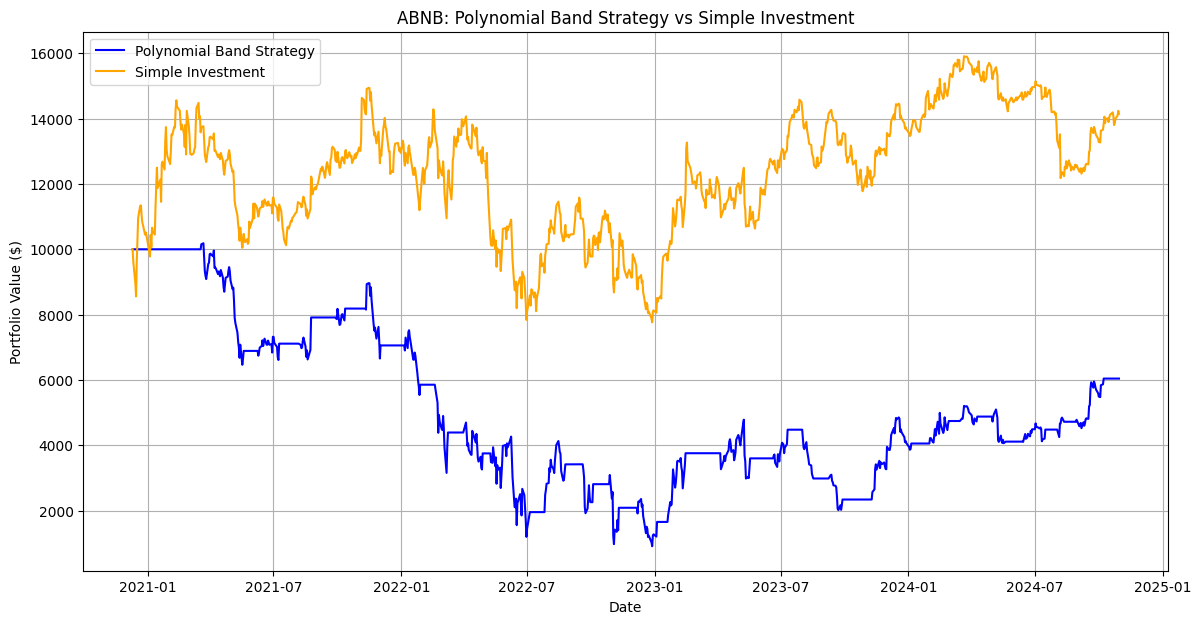

In [14]:
# Plotting the results for ABNB
abnb_df = holder_signals["ABNB"]
plt.figure(figsize=(14, 7))
plt.plot(abnb_df.index, abnb_df["Strategy_Portfolio_Value"], label="Polynomial Band Strategy", color='blue')
plt.plot(abnb_df.index, abnb_df["Simple_Portfolio_Value"], label="Simple Investment", color='orange')
plt.title("ABNB: Polynomial Band Strategy vs Simple Investment")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid()
plt.show()

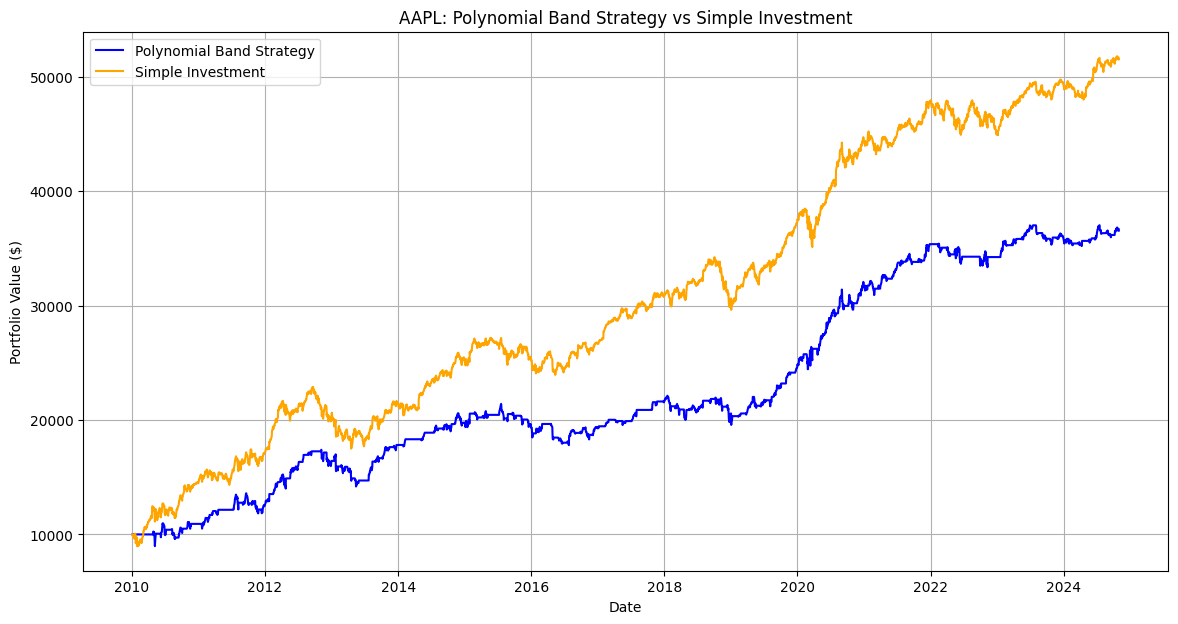

In [15]:
# analyze AAPL as well
aapl_df = holder_signals["AAPL"]
plt.figure(figsize=(14, 7))
plt.plot(aapl_df.index, aapl_df["Strategy_Portfolio_Value"], label="Polynomial Band Strategy", color='blue')
plt.plot(aapl_df.index, aapl_df["Simple_Portfolio_Value"], label="Simple Investment", color='orange')
plt.title("AAPL: Polynomial Band Strategy vs Simple Investment")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid()
plt.show()

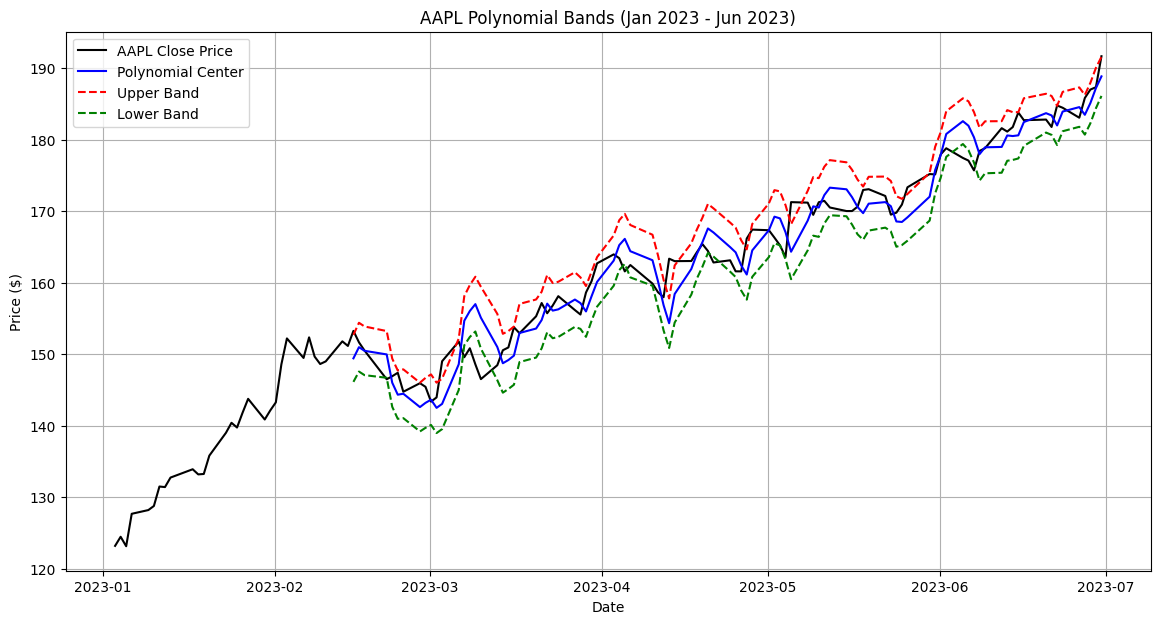

In [16]:
# lets look at a polynomial fit on AAPL, but on one 6 month period
aapl_sample = holder["AAPL"].loc['2023-01-01':'2023-06-30'].copy()
aapl_sample = compute_polynomial_bands(aapl_sample, degree=4, window=30, k=2)
plt.figure(figsize=(14, 7))
plt.plot(aapl_sample.index, aapl_sample["Close"], label="AAPL Close Price", color='black')
plt.plot(aapl_sample.index, aapl_sample["Poly_Center"], label="Polynomial Center", color='blue')
plt.plot(aapl_sample.index, aapl_sample["Upper_Band"], label="Upper Band", color='red', linestyle='--')
plt.plot(aapl_sample.index, aapl_sample["Lower_Band"], label="Lower Band", color='green', linestyle='--')
plt.title("AAPL Polynomial Bands (Jan 2023 - Jun 2023)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid()
plt.show()

In [17]:
# calculate annual percentage performance from strategy and simple investment
def calculate_annual_performance(df):
    df = df.copy()
    df['Year'] = df.index.year
    performance = {}

    for year, group in df.groupby('Year'):
        if len(group) < 2:
            continue
        start_value_strategy = group['Strategy_Portfolio_Value'].iloc[0]
        end_value_strategy = group['Strategy_Portfolio_Value'].iloc[-1]
        annual_return_strategy = (end_value_strategy - start_value_strategy) / start_value_strategy * 100

        start_value_simple = group['Simple_Portfolio_Value'].iloc[0]
        end_value_simple = group['Simple_Portfolio_Value'].iloc[-1]
        annual_return_simple = (end_value_simple - start_value_simple) / start_value_simple * 100

        performance[year] = {
            'Strategy_Return (%)': annual_return_strategy,
            'Simple_Return (%)': annual_return_simple
        }

    return pd.DataFrame.from_dict(performance, orient='index')

# create new csv directory for performance results
performance_directory = "percentage_performance"
if not os.path.exists(performance_directory):
    os.makedirs(performance_directory)
for symbol, df in holder_signals.items():
    performance_df = calculate_annual_performance(df)
    performance_csv_path = os.path.join(performance_directory, f"{symbol}_performance.csv")
    performance_df.to_csv(performance_csv_path)

In [ ]:
# make a list of all trades made by the strategy for every symbol
directory = "trade_data"
if not os.path.exists(directory):
    os.makedirs(directory)

for symbol, df in holder_signals.items():
    # Find position changes (trades)
    df_copy = df.copy()
    df_copy['Position_Change'] = df_copy['Position'].diff()
    
    # Entry: Position changes from 0 to 1 (Position_Change = 1)
    # Exit: Position changes from 1 to 0 (Position_Change = -1)
    
    entries = df_copy[df_copy['Position_Change'] == 1].copy()
    exits = df_copy[df_copy['Position_Change'] == -1].copy()
    
    trades = []
    
    for i in range(len(entries)):
        entry_date = entries.index[i]
        entry_price = entries.loc[entry_date, "Close"]
        
        future_exits = exits[exits.index > entry_date]
        
        if len(future_exits) == 0:
            # no exit yet, trade is still open
            continue
            
        exit_date = future_exits.index[0]
        exit_price = exits.loc[exit_date, "Close"]
        
        trade_return = (exit_price - entry_price) / entry_price
        holding_days = (exit_date - entry_date).days
        
        trades.append({
            "Entry_Date": entry_date,
            "Exit_Date": exit_date,
            "Entry_Price": entry_price,
            "Exit_Price": exit_price,
            "Return": trade_return,
            "Return_Pct": trade_return * 100,
            "Holding_Days": holding_days
        })
    
    trades_df = pd.DataFrame(trades)
    trades_csv_path = os.path.join(directory, f"{symbol}_trades.csv")
    trades_df.to_csv(trades_csv_path, index=False)

Trade data saved for 86 symbols

Example: AAPL had 102 trades
